In [42]:
from __future__ import print_function
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [43]:
# Root directory for dataset
dataroot = "data"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 32 

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32 

# Number of training epochs
num_epochs = 10 

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [82]:
os.makedirs("data", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10(
        "data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=128,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
#real_batch = next(iter(dataloader))
#plt.figure(figsize=(8,8))
#plt.axis("off")
#plt.title("Training Images")
#plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Files already downloaded and verified


# Model Parameters

In [71]:
latent_dim = 128
n_category = 2

# Model Architecture

In [45]:
class FadeIn(nn.Module):
  def __init__(self):
    super(FadeIn, self).__init__()
    self.alpha = 0

  def update_alpha(self, delta):
    self.alpha = min(1.0, self.alpha + delta)
  
  def forward(self, x, y):
    return torch.add(x.mul(1.0 - self.alpha), y.mul(self.alpha))

In [46]:
class ImageReducer(nn.Module):
  def __init__(self, channel_size):
    super(ImageReducer, self).__init__()
    self.conv = nn.Conv2d(in_channels=channel_size, out_channels=channel_size, kernel_size=2, stride=2)

  def forward(self, x):
    reduced_image = self.conv(x)
    return reduced_image

In [68]:
class GrowableGenerator(nn.Module):
  def __init__(self, n_layers):
    super(GrowableGenerator, self).__init__()
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
    self.n_layers = n_layers
    self.layers = nn.ModuleList()
    self.fadein_layers = nn.ModuleList()
    self.toRGB_layers = nn.ModuleList()

    self.layers.append(self.initial_block())
    for i in range(n_layers):
      if i != 0:
        self.layers.append(self.intermediate_block())
      self.toRGB_layers.append(self.toRGB_block(512))
      self.fadein_layers.append(FadeIn())
    
  def toRGB_block(self, latent_dim):
    return nn.Sequential(
        nn.Conv2d(latent_dim, 3, 1, 1, 0)
    )
  
  def initial_block(self):
    return nn.Sequential(
        nn.Conv2d(latent_dim + n_category, latent_dim, 4, 1, 3),
        nn.LeakyReLU(0.2),
        nn.Conv2d(latent_dim, latent_dim, 3, 1, 1),
        nn.LeakyReLU(0.2),
    )
  
  def intermediate_block(self):
    return nn.Sequential(
    nn.Upsample(scale_factor=2, mode='bilinear'),
    nn.Conv2d(latent_dim, latent_dim, 3, 1, 1),
    nn.LeakyReLU(0.2),
    nn.Conv2d(latent_dim, latent_dim, 3, 1, 1),
    nn.LeakyReLU(0.2),
    )
    
  def update_alpha(self, alpha, gen):
    self.fadein_layers[gen].update_alpha(alpha)
    
  def forward(self, x, gen):
    if gen > self.n_layers:
      print("ERROR")
      exit()
    for i in range(gen+1):
      if gen != 0 and i == gen:
        x1 = self.layers[i](x)
        x1 = self.toRGB_layers[gen](x1)
        x2 = self.toRGB_layers[gen-1](x)
        x2 = self.upsample(x2)
        x = self.fadein_layers[gen](x2, x1)
      elif i == gen:
        x = self.layers[i](x)
        x = self.toRGB_layers[gen](x)
      else:
        x = self.layers[i](x)
    return x

In [75]:
class GrowableDiscriminator(nn.Module):
  def __init__(self, n_layers):
    super(GrowableDiscriminator, self).__init__()
    channel_size = 16
    self.n_layers = n_layers
    self.fadein_layers = nn.ModuleList()
    self.downsample = nn.AvgPool2d(kernel_size=2)
    self.fromRGB_layers = nn.ModuleList()
    self.layers = nn.ModuleList()

    for i in range(n_layers, 0, -1):
      #resolution = 2 ** (i + 3)
      self.fromRGB_layers.append(self.fromRGB_block(latent_dim))
      if i != n_layers:
        self.layers.append(self.intermediate_block(latent_dim))
      self.fadein_layers.append(FadeIn())
    self.fromRGB_layers = nn.ModuleList(reversed(self.fromRGB_layers))
    self.layers = nn.ModuleList(reversed(self.layers))
    self.layers.append(self.final_block(n_layers))

  def fromRGB_block(self, latent_dim):
    return nn.Sequential(
        nn.Conv2d(3, latent_dim, 1, 1, 0)
    )

  def intermediate_block(self, latent_dim):
    return nn.Sequential(
      nn.Conv2d(latent_dim, latent_dim, 3, 1, 1),
      nn.LeakyReLU(0.2, inplace=True),
      #nn.Conv2d(resolution, resolution * 2, 3, 1, 1),
      nn.Conv2d(latent_dim, latent_dim, 3, 1, 1),
      nn.LeakyReLU(0.2, inplace=True),
      nn.AvgPool2d(kernel_size=2)
    )
  
  def final_block(self, n_layers):
    #resolution = 2 ** (n_layers + 3)
    return nn.Sequential(
          nn.Conv2d(latent_dim, latent_dim, 3, 1, 1),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Conv2d(latent_dim, latent_dim, 4, 1, 0),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Flatten(),
          nn.Linear(latent_dim, 11),
    )

  def update_alpha(self, alpha, gen):
    target_layer = self.n_layers - 1 - gen
    self.fadein_layers[target_layer].update_alpha(alpha)

  def forward(self, x, gen):
    if gen > self.n_layers:
      print("ERROR")
      exit()
    x1 = self.fromRGB_layers[self.n_layers - gen - 1](x)
    for i in range(gen+1):
      target_layer = self.n_layers - 1 - gen + i
      x1 = self.layers[target_layer](x1)
      if gen != 0 and i == 0:
        x2 = self.downsample(x)
        x2 = self.fromRGB_layers[target_layer + 1](x2)
        x1 = self.fadein_layers[target_layer](x2, x1)
        
    return x1

In [72]:
# Create the generator
netG = GrowableGenerator(4).to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
#netG.apply(weights_init)

# Print the model
print(netG)

GrowableGenerator(
  (upsample): Upsample(scale_factor=2.0, mode=bilinear)
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(138, 128, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Upsample(scale_factor=2.0, mode=bilinear)
      (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Upsample(scale_factor=2.0, mode=bilinear)
      (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.2)


In [76]:
# Create the Discriminator
netD = GrowableDiscriminator(4).to(device)


# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
#netD.apply(weights_init)

# Print the model
print(netD)

GrowableDiscriminator(
  (fadein_layers): ModuleList(
    (0): FadeIn()
    (1): FadeIn()
    (2): FadeIn()
    (3): FadeIn()
  )
  (downsample): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fromRGB_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Sequential(
      (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Sequential(
      (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): Sequential(
      (0): Conv2d(3, 128, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): AvgPool2d(kernel_size=2, stride=2, padding=0)
    )
    (1): Sequential(
      (0): Conv2d(128, 

In [51]:
def create_label_fake(i, n):
    label = torch.ones((n,3))
    for a in range(n):
        label[a,-1] = 0
    return label

def create_label_real(i, n):
    return torch.nn.functional.one_hot(i, 3).to(torch.float)

In [52]:
# Initialize the ``BCELoss`` function
#criterion = nn.BCELoss()
##criterion test 1 to replace to categorial crossentropy loss
criterion = nn.BCEWithLogitsLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
#fixed_noise = torch.randn(64, 256, 1, 1, device=device)
fixed_noise = torch.cat([torch.randn(64, 512, 1, 1, device=device), create_label_real(torch.randint(0, 10, (64,)), 64)[:,:-1].unsqueeze(-1).unsqueeze(-1).to(device)],dim=1)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
#optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
#optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


#image reducer
#reducer = ImageReducer(3)
reducer = nn.AvgPool2d(kernel_size=2)

In [53]:
optimizerD = optim.Adam(netD.parameters(), lr=0.00009, betas=(0, 0.99))
optimizerG = optim.Adam(netG.parameters(), lr=0.00009, betas=(0, 0.99))

In [54]:
def save_images(images):
  fake = netG(fixed_noise, 1, 1).detach().cpu()
  plt.figure(figsize=(16,16))
  plt.imshow(np.transpose(vutils.make_grid(images, padding=5, normalize=True), (1, 2, 0)))

In [55]:
if torch.cuda.is_available():
    netD = nn.DataParallel(netD)
    netG = nn.DataParallel(netG)

In [56]:
def generate_image(gen):
  with torch.no_grad():
    vec = torch.cat([torch.randn(64, 512, 1, 1, device=device), create_label_real(torch.randint(0, 10, (64,)), 64)[:,:-1].unsqueeze(-1).unsqueeze(-1).to(device)],dim=1)
    fake = netG(vec, gen).detach().cpu() 
    #fake = netG(fixed_noise, 3).detach().cpu()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(vutils.make_grid(fake.detach(), padding=5, normalize=True), (1, 2, 0)))
    print(fake[0])

In [57]:
#netD.load_state_dict(torch.load('discriminator3.pt'))
#netG.load_state_dict(torch.load('generator3.pt'))

In [58]:
# Training Loop
torch.backends.cudnn.benchmark = True

# Lists to keep track of progress
img_list = [[],[],[],[],[]]
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")

epoch_list = [120, 120, 160, 240, 30]
#epoch_list = [30, 30, 50, 100, 30]
#epoch_list = [1, 1, 1, 1, 1]
# For each epoch
for gen in range(0, 4):
  print('gen=' + str(gen))
  #for epoch in range(num_epochs):
  for epoch in range(epoch_list[gen]):
      # For each batch in the dataloader
      for i, data in enumerate(dataloader, 0):
          ############################
          # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
          ###########################
          ## Train with all-real batch
          netD.zero_grad()
          for _ in range(3 - gen):
            data[0] = reducer(data[0])
          real_cpu = data[0].to(device)
          b_size = real_cpu.size(0)
          #label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
          label = create_label_real(data[1], b_size).to(device)
          output = netD(real_cpu, gen)
          # Calculate loss on all-real batch
          errD_real = criterion(output, label)
          # Calculate gradients for D in backward pass
          errD_real.backward()
          D_x = output.mean().item()
  
          ## Train with all-fake batch
          # Generate batch of latent vectors
          target_image_vector = create_label_real(data[1], b_size).to(device)
          noise = torch.cat([torch.randn(b_size, 512, 1, 1, device=device), target_image_vector[:,:-1].unsqueeze(-1).unsqueeze(-1)],dim=1)
          #print("noise")
          #print(noise.shape)
          # Generate fake image batch with G
          fake = netG(noise, gen)
          #label.fill_(fake_label)
          label = create_label_fake(torch.zeros(b_size), b_size).to(device)
          # Classify all fake batch with D
          output = netD(fake.detach(), gen)
          #print(output.shape)
          #print(label.shape)
          # Calculate D's loss on the all-fake batch
          errD_fake = criterion(output, label)
          # Calculate the gradients for this batch, accumulated (summed) with previous gradients
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          # Compute error of D as sum over the fake and the real batches
          errD = errD_real + errD_fake
          # Update D
          optimizerD.step()
  
          ############################
          # (2) Update G network: maximize log(D(G(z)))
          ###########################
          netG.zero_grad()
          #label.fill_(real_label)  # fake labels are real for generator cost
          label = target_image_vector
          # Since we just updated D, perform another forward pass of all-fake batch through D
          output = netD(fake, gen)
          # Calculate G's loss based on this output
          errG = criterion(output, label)
          # Calculate gradients for G
          errG.backward()
          D_G_z2 = output.mean().item()
          # Update G
          optimizerG.step()
          #break
  
          # Output training stats
          if i % 50 == 0:
              print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, epoch_list[gen], i, len(dataloader),
                      errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
  
          # Save Losses for plotting later
          G_losses.append(errG.item())
          D_losses.append(errD.item())
        #save_images(netG(fixed_noise, gen, 1).detach().cpu())
          # Check how the generator is doing by saving G's output on fixed_noise
          if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
              with torch.no_grad():
                  fake = netG(fixed_noise, gen).detach().cpu()
              img_list[gen].append(vutils.make_grid(fake, padding=2, normalize=True))
  
          iters += 1
      netD.module.update_alpha(0.015, gen)
      netG.module.update_alpha(0.015, gen)
      print('netG alpha=', netG.module.fadein_layers[gen].alpha)
      print('netD alpha=', netD.module.fadein_layers[4 - 1 - gen].alpha)
  torch.save(netG.state_dict(), 'generator'+str(gen)+'.pt')
  torch.save(netD.state_dict(), 'discriminator'+str(gen)+'.pt')

Starting Training Loop...
gen=0
[0/120][0/391]	Loss_D: 1.3868	Loss_G: 0.6907	D(x): 0.0165	D(G(z)): 0.0166 / -0.0021
[0/120][50/391]	Loss_D: 0.7254	Loss_G: 1.6810	D(x): -2.0452	D(G(z)): 0.2951 / 1.1762
[0/120][100/391]	Loss_D: 1.0904	Loss_G: 0.9381	D(x): -0.4919	D(G(z)): 0.0571 / 0.1913
[0/120][150/391]	Loss_D: 1.3475	Loss_G: 0.7624	D(x): -0.2886	D(G(z)): -0.4201 / -0.2082
[0/120][200/391]	Loss_D: 1.2444	Loss_G: 0.7435	D(x): -0.3828	D(G(z)): -0.3849 / -0.3328
[0/120][250/391]	Loss_D: 1.2052	Loss_G: 0.7776	D(x): -0.4866	D(G(z)): -0.3418 / -0.2383
[0/120][300/391]	Loss_D: 1.2694	Loss_G: 0.7332	D(x): -0.3420	D(G(z)): -0.3729 / -0.3551
[0/120][350/391]	Loss_D: 1.2098	Loss_G: 0.7987	D(x): -0.4064	D(G(z)): -0.3445 / -0.2041
netG alpha= 0.015
netD alpha= 0.015
[1/120][0/391]	Loss_D: 1.2193	Loss_G: 0.7406	D(x): -0.2587	D(G(z)): -0.1779 / -0.3315
[1/120][50/391]	Loss_D: 1.2283	Loss_G: 0.7343	D(x): -0.5021	D(G(z)): -0.4382 / -0.3935
[1/120][100/391]	Loss_D: 1.2324	Loss_G: 0.7178	D(x): -0.4423	D(G

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:3393: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


[0/120][0/391]	Loss_D: 1.1725	Loss_G: 1.0487	D(x): -3.9340	D(G(z)): -3.3074 / -2.6189
[0/120][50/391]	Loss_D: 1.1020	Loss_G: 1.0270	D(x): -3.9184	D(G(z)): -3.3757 / -2.7396
[0/120][100/391]	Loss_D: 1.0613	Loss_G: 0.8856	D(x): -3.7206	D(G(z)): -3.0035 / -2.9611
[0/120][150/391]	Loss_D: 1.0743	Loss_G: 0.9183	D(x): -3.6820	D(G(z)): -3.1868 / -2.9569
[0/120][200/391]	Loss_D: 1.0350	Loss_G: 0.8847	D(x): -3.8579	D(G(z)): -3.1377 / -2.9296
[0/120][250/391]	Loss_D: 1.0790	Loss_G: 0.9677	D(x): -3.8316	D(G(z)): -3.2678 / -2.8706
[0/120][300/391]	Loss_D: 1.0638	Loss_G: 0.9110	D(x): -3.8640	D(G(z)): -3.1399 / -2.8813
[0/120][350/391]	Loss_D: 1.1006	Loss_G: 0.9709	D(x): -3.8609	D(G(z)): -3.3181 / -2.8216
netG alpha= 0.015
netD alpha= 0.015
[1/120][0/391]	Loss_D: 1.0933	Loss_G: 1.0095	D(x): -3.8669	D(G(z)): -3.3143 / -2.7955
[1/120][50/391]	Loss_D: 1.0905	Loss_G: 0.8980	D(x): -3.7747	D(G(z)): -3.1671 / -2.8657
[1/120][100/391]	Loss_D: 1.1315	Loss_G: 0.9005	D(x): -3.5133	D(G(z)): -3.0677 / -3.1010
[1

KeyboardInterrupt: 

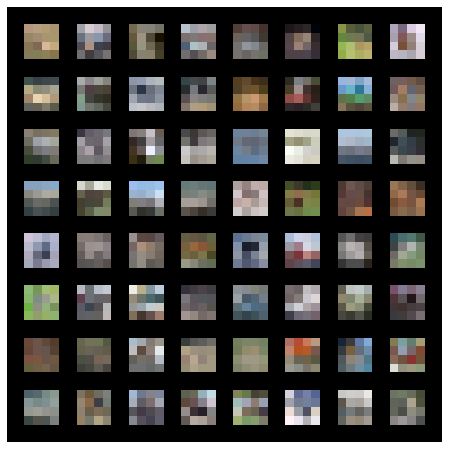

In [90]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[0]]
#plt.rcParams['animation.embed_limit'] = 2**128
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[1]]
#plt.rcParams['animation.embed_limit'] = 2**128
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

KeyboardInterrupt: 

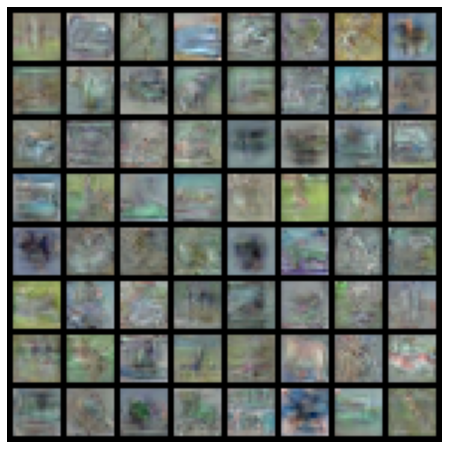

In [88]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[2]]
#plt.rcParams['animation.embed_limit'] = 2**128
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

KeyboardInterrupt: 

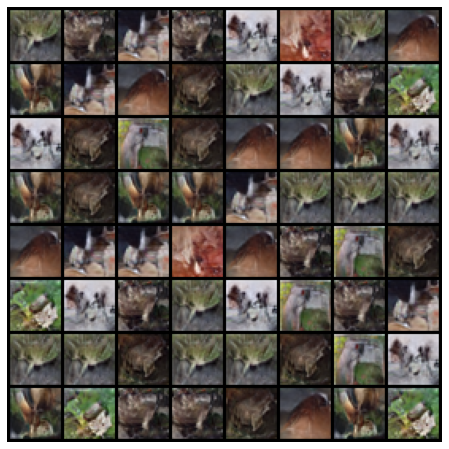

In [87]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list[3]]
#plt.rcParams['animation.embed_limit'] = 2**128
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
HTML(ani.to_jshtml())

Text(0.5, 1.0, 'Fake Images')

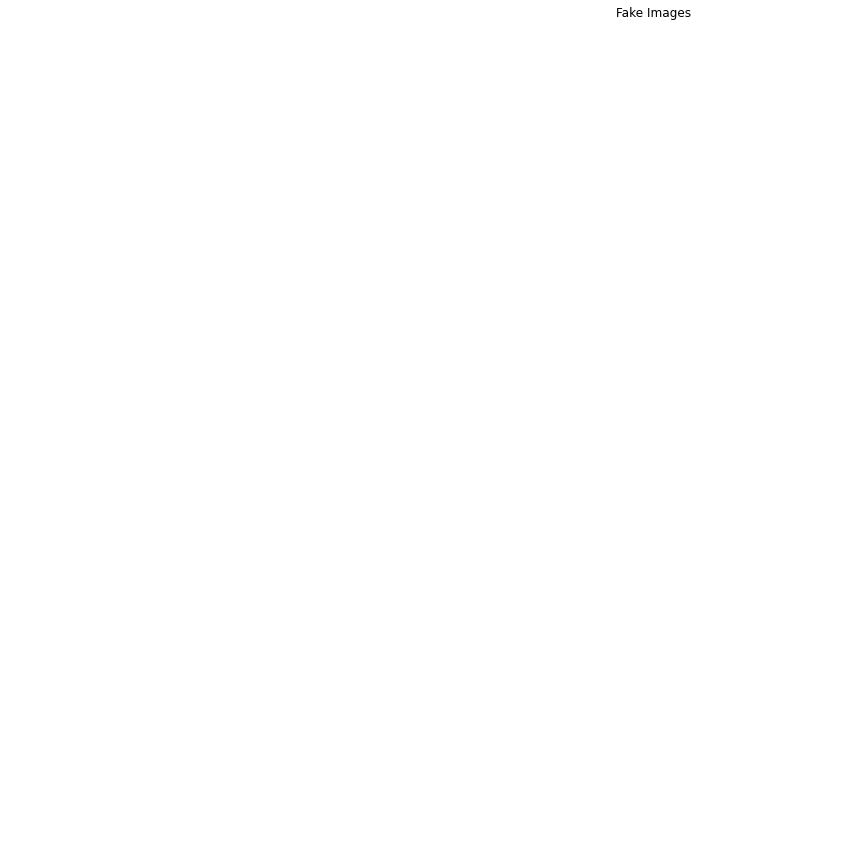

In [86]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
#plt.title("Real Images")
#plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
#plt.imshow(np.transpose(img_list[3][-1],(1,2,0)))
#plt.show()

tensor([[[ 0.8039,  0.8275,  0.6549,  ...,  0.0902, -0.0510, -0.0902],
         [ 0.7961,  0.7882,  0.7647,  ..., -0.0902, -0.1529, -0.1608],
         [ 0.7882,  0.6314,  0.7333,  ...,  0.1373,  0.1922,  0.1373],
         ...,
         [-0.7098, -0.6549, -0.7020,  ..., -0.6471, -0.6784, -0.7255],
         [-0.6549, -0.6863, -0.6314,  ..., -0.7255, -0.7725, -0.7804],
         [-0.4510, -0.4745, -0.2314,  ..., -0.8039, -0.8353, -0.8353]],

        [[-0.3725, -0.3647, -0.2235,  ...,  0.2706,  0.1294,  0.1059],
         [-0.1843,  0.0118,  0.2627,  ...,  0.1059,  0.0510,  0.0510],
         [ 0.1059,  0.1686,  0.4902,  ...,  0.3647,  0.4196,  0.3647],
         ...,
         [-0.5294, -0.4980, -0.5686,  ..., -0.4980, -0.4431, -0.4745],
         [-0.4745, -0.5373, -0.4980,  ..., -0.5059, -0.5373, -0.5843],
         [-0.3020, -0.3412, -0.1137,  ..., -0.6078, -0.6471, -0.7020]],

        [[-0.4980, -0.4118, -0.4902,  ..., -0.1843, -0.3255, -0.4118],
         [-0.2863, -0.1686, -0.2314,  ..., -0

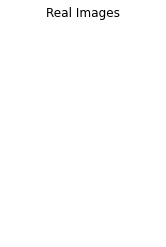

<Figure size 1080x1080 with 0 Axes>

In [83]:
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
reduce_num = 0
images = real_batch[0][:64]
for i in range(reduce_num):
  images = reducer(images)
plt.figure(figsize=(15,15))
#plt.imshow(np.transpose(vutils.make_grid(images, padding=5, normalize=True).cpu(),(1,2,0)))
#plt.show()
print(images[1])

In [65]:
with torch.no_grad():
  vec = torch.cat([torch.randn(64, 256, 1, 1, device=device), create_label_real(torch.randint(0, 10, (64,)), 64)[:,:-1].unsqueeze(-1).unsqueeze(-1).to(device)],dim=1)
  fake = netG(vec, 3).detach().cpu() 
  #fake = netG(fixed_noise, 3).detach().cpu()
  plt.figure(figsize=(15,15))
  plt.imshow(np.transpose(vutils.make_grid(fake.detach(), padding=5, normalize=True), (1, 2, 0)))

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 881, in _call_impl
    result = self.forward(*input, **kwargs)
  File "<ipython-input-47-8794600ca727>", line 59, in forward
    x = self.layers[i](x)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 881, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/container.py", line 117, in forward
    input = module(input)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py", line 881, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/conv.py", line 394, in forward
    return self._conv_forward(input, self.weight, self.bias)
  File "/opt/conda/lib/python3.8/site-packages/torch/nn/modules/conv.py", line 390, in _conv_forward
    return F.conv2d(input, weight, bias, self.stride,
RuntimeError: Given groups=1, weight of size [512, 522, 4, 4], expected input[32, 266, 1, 1] to have 522 channels, but got 266 channels instead


In [ ]:
with torch.no_grad():
  vec = torch.cat([torch.randn(10, 256, 1, 1, device=device), create_label_real(torch.tensor(list(range(10))), 10)[:,:-1].unsqueeze(-1).unsqueeze(-1).to(device)],dim=1)
  fake = netG(vec, 3).detach().cpu() 
  #fake = netG(fixed_noise, 3).detach().cpu()
  plt.figure(figsize=(15,15))
  plt.imshow(np.transpose(vutils.make_grid(fake.detach(), padding=5, normalize=True), (1, 2, 0)))
  print(fake[0])

In [ ]:
torch.save(netG.state_dict(), 'generator.pt')
torch.save(netD.state_dict(), 'discriminator.pt')